In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots

plt.style.use(["grid", "notebook", "science", "ieee"])

In [2]:
df = pd.read_csv("data.csv")
df.head()

,id,diagnosis,Radius_mean,Texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,21.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.metrics import classification_report, confusion_matrix, log_loss

In [4]:
X, y = df.iloc[:, 2:], df.iloc[:, 1]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, shuffle=True)

### MinMaxScaler

In [5]:
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(X_train)

X_train_scaled = min_max_scaler.transform(X_train)
X_test_scaled = min_max_scaler.transform(X_test)

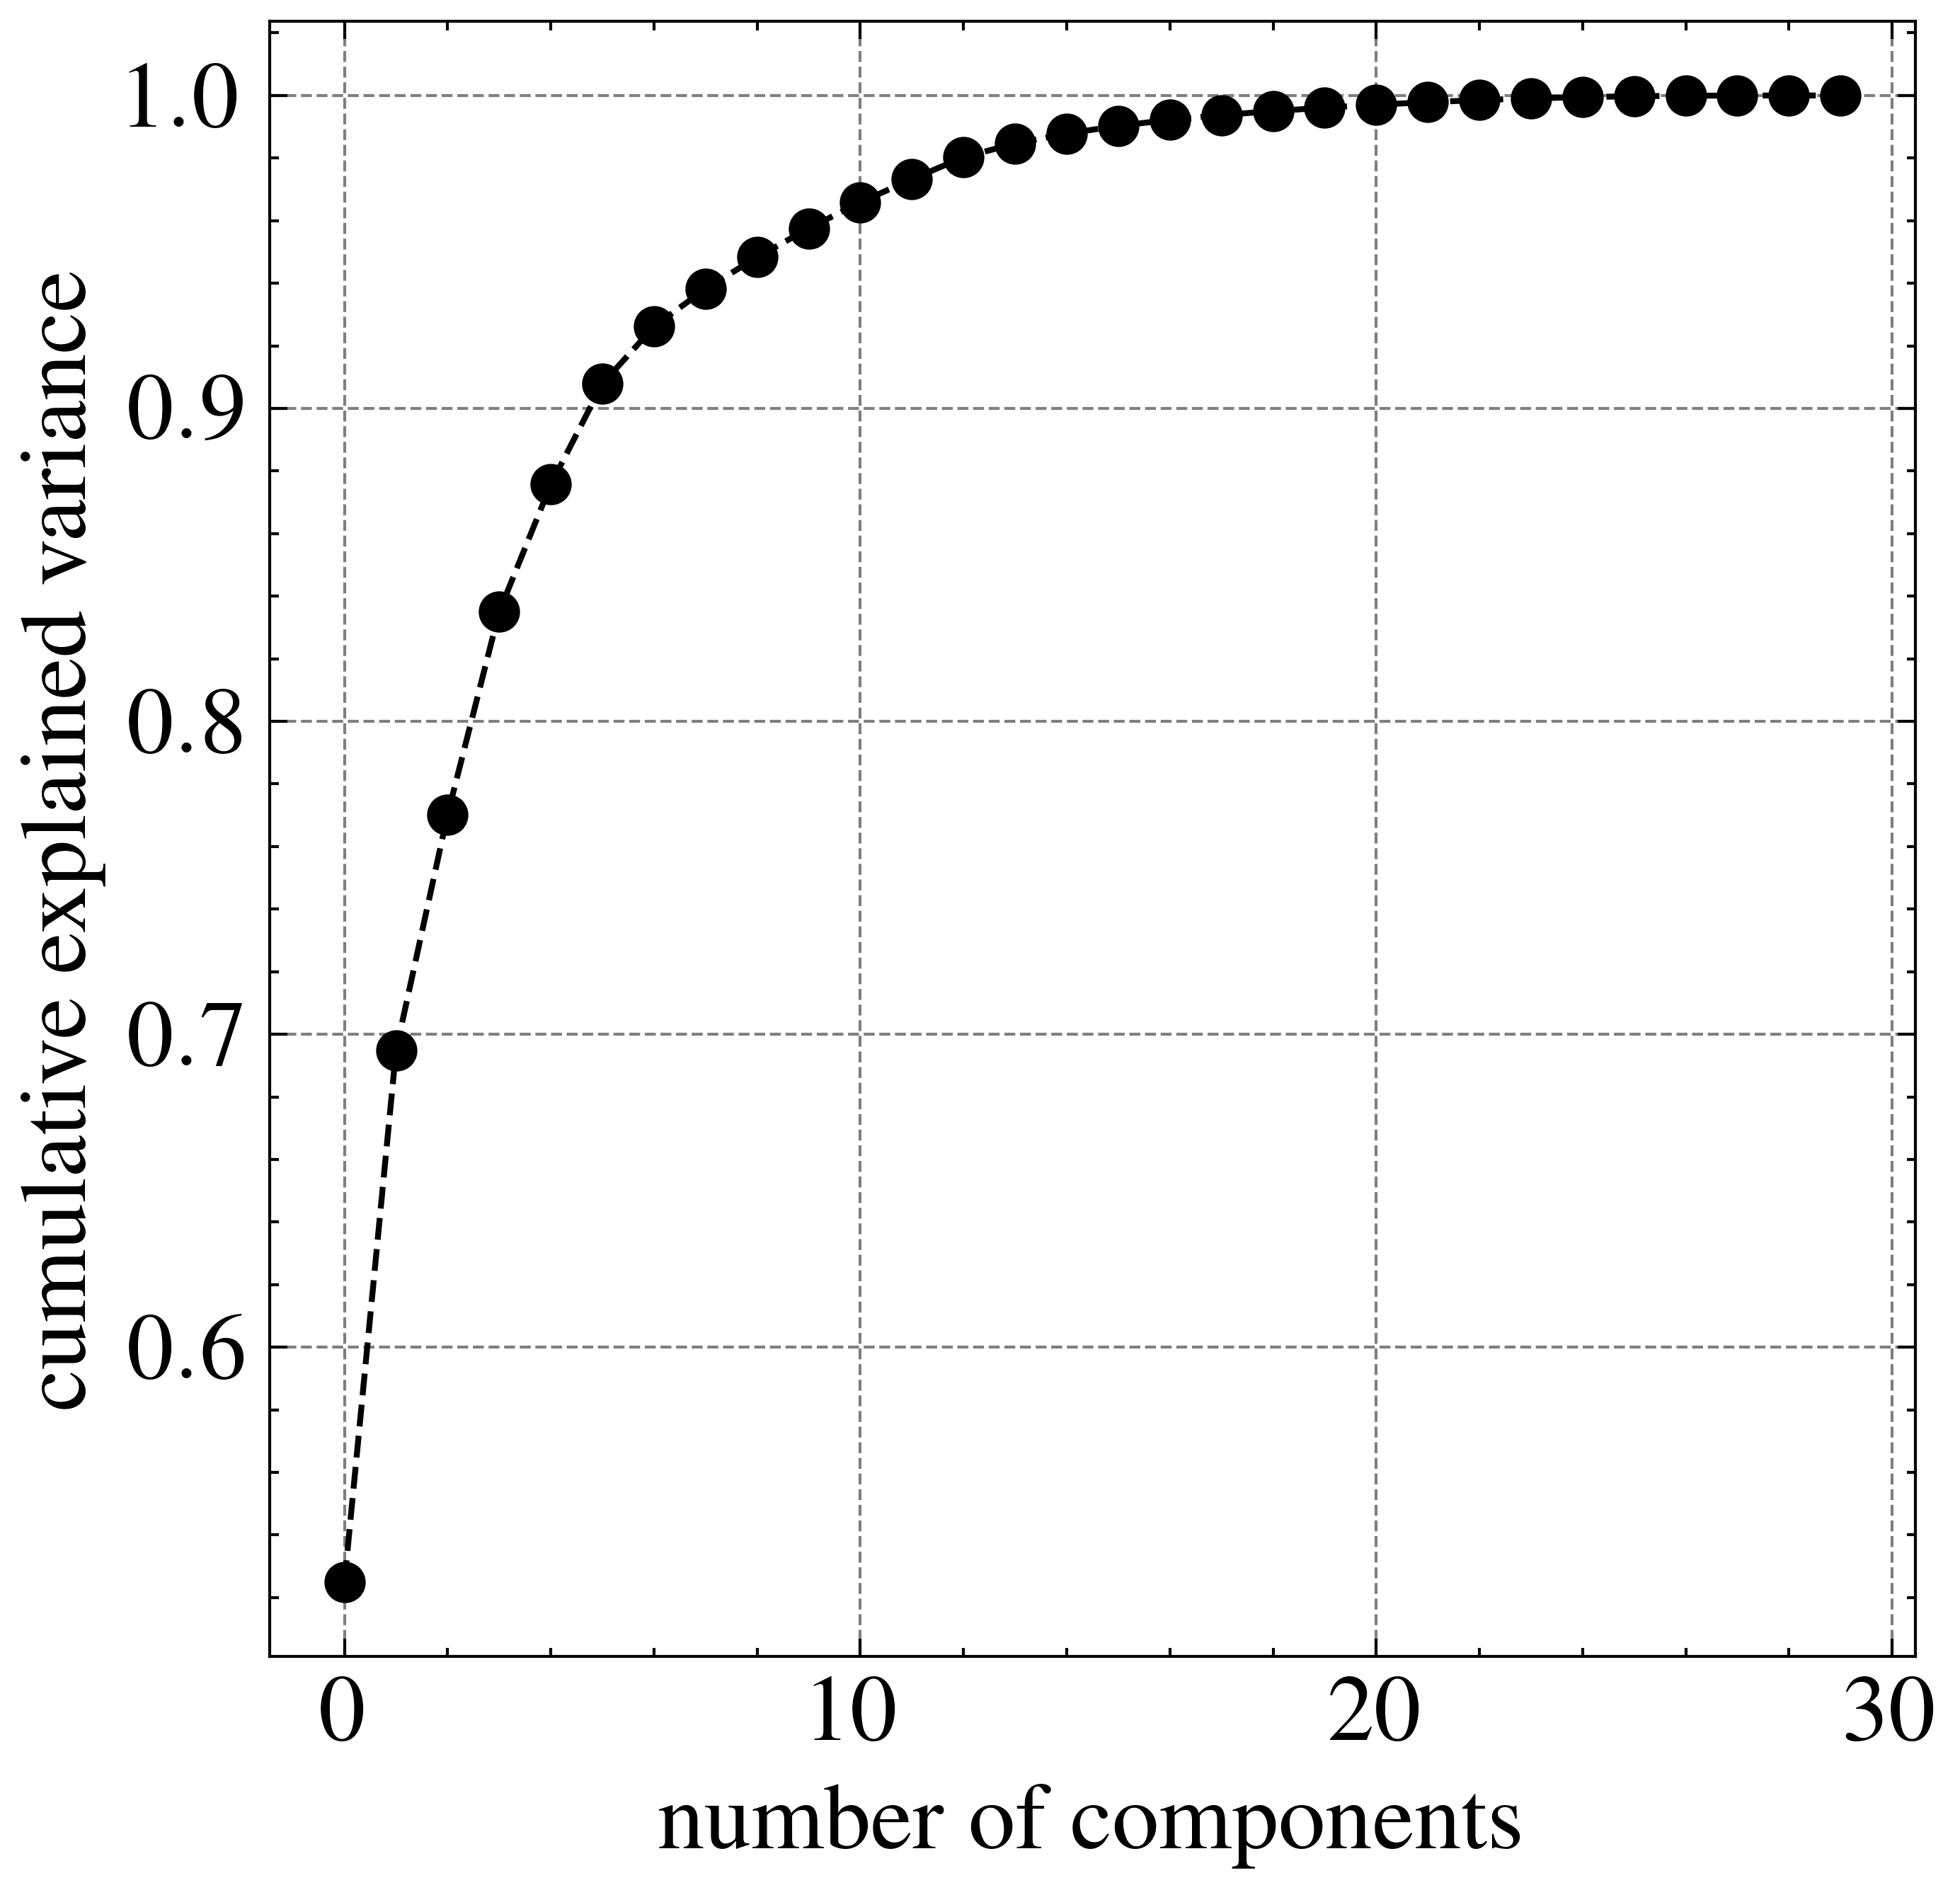

In [6]:
pca = PCA().fit(X_train_scaled)
plt.figure(figsize=(5, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), "o--")
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [7]:
pca = PCA(n_components=20).fit(X_train_scaled)
X_train_reduced = pca.transform(X_train_scaled)
X_test_reduced = pca.transform(X_test_scaled)

## K-Nearest Neighbors (KNN)

In [8]:
knn = GridSearchCV(KNeighborsClassifier(), {
    "n_neighbors": [i for i in range(1, 21)],
    "weights": ["uniform", "distance"],
    "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
    "p": [1, 2],
}, scoring='accuracy', cv=5)

In [9]:
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)

In [10]:
knn.best_params_

{'algorithm': 'auto', 'n_neighbors': 4, 'p': 1, 'weights': 'distance'}

In [11]:
k_nearest_neighbors = KNeighborsClassifier(
    n_neighbors=knn.best_params_["n_neighbors"],
    weights=knn.best_params_["weights"],
    p=knn.best_params_["p"],
    algorithm=knn.best_params_["algorithm"]
)

In [12]:
k_nearest_neighbors.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=4, p=1, weights='distance')

In [13]:
y_pred = k_nearest_neighbors.predict(X_test_scaled)

In [14]:
pred_probabilities = k_nearest_neighbors.predict_proba(X_test_scaled)

### Model Evaluation

In [15]:
print("Accuracy:", k_nearest_neighbors.score(X_test_scaled, y_test))

Accuracy: 0.951048951048951


In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           B       0.95      0.98      0.96        88
           M       0.96      0.91      0.93        55

    accuracy                           0.95       143
   macro avg       0.95      0.94      0.95       143
weighted avg       0.95      0.95      0.95       143



In [17]:
cm = confusion_matrix(y_test, y_pred)

cm

array([[86,  2],
       [ 5, 50]], dtype=int64)

In [18]:
cm_normalized = cm / cm.sum(axis=1).reshape(-1, 1)

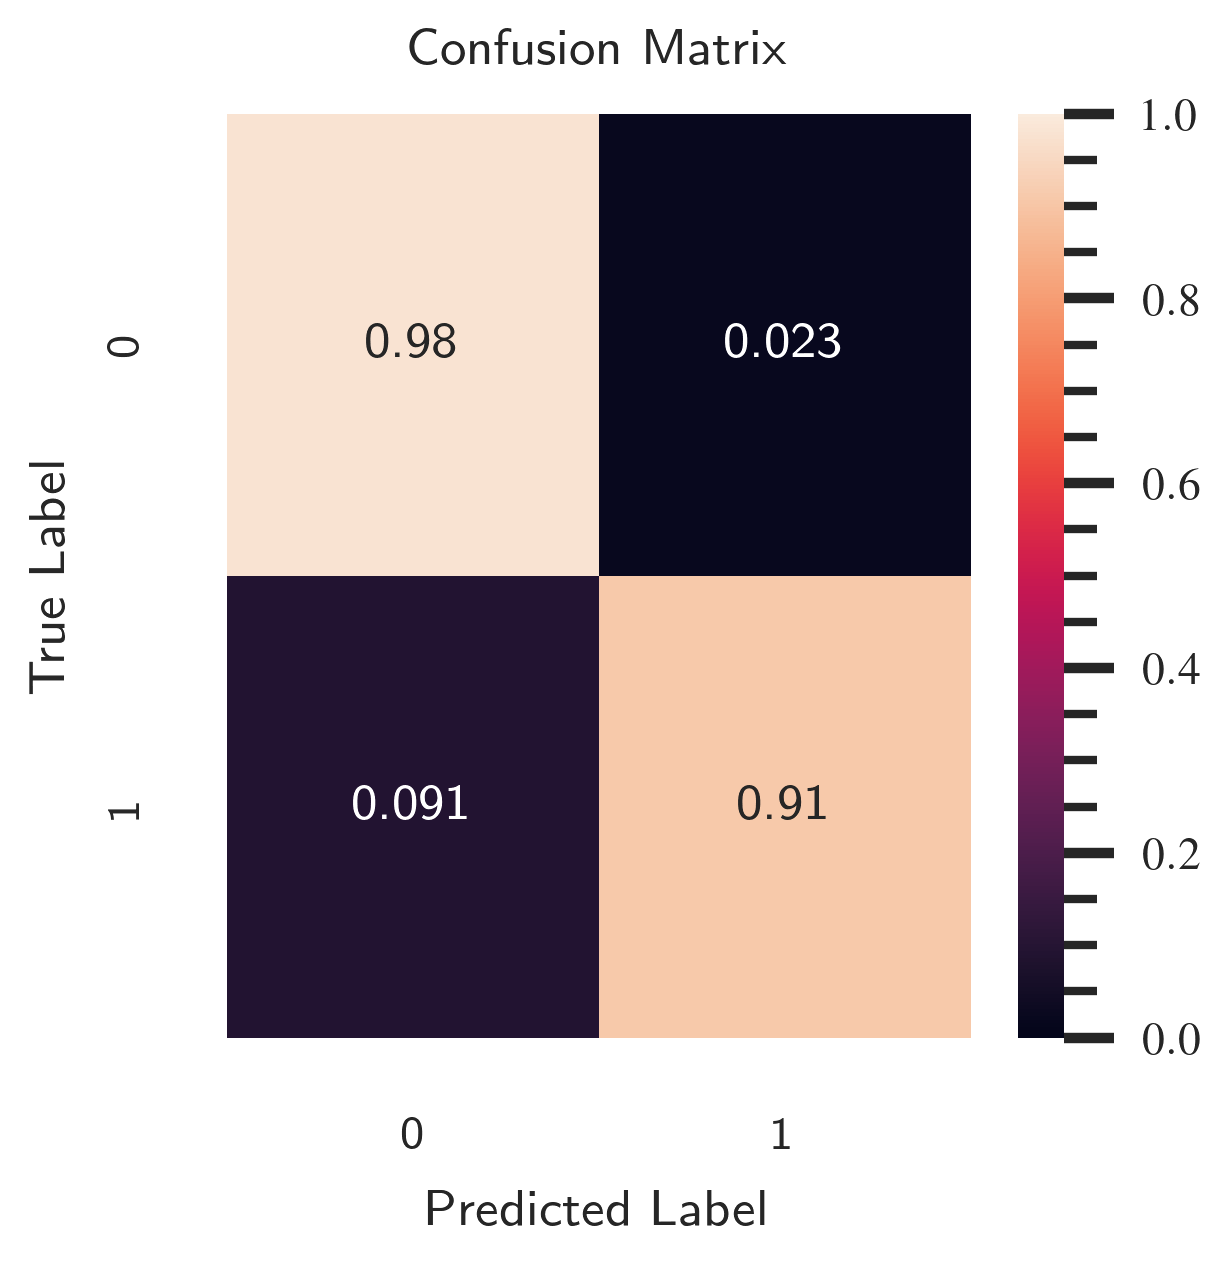

In [19]:
plt.figure(figsize=(2, 2))
sns.set(font_scale=.5)
sns.heatmap(cm_normalized, vmin=0, vmax=1, annot=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [20]:
false_positive = cm.sum(axis=0) - np.diag(cm)
false_negative = cm.sum(axis=1) - np.diag(cm)
true_positive = np.diag(cm)
true_negative = cm.sum() - (false_positive + false_negative + true_positive)

In [21]:
true_positive_rate = true_positive / (true_positive + false_negative)
true_positive_rate

array([0.97727273, 0.90909091])

In [22]:
positive_predictive_value = true_positive / (true_positive + false_positive)
positive_predictive_value

array([0.94505495, 0.96153846])

In [23]:
false_positive_rate = false_positive / (false_positive + true_negative)
false_positive_rate 

array([0.09090909, 0.02272727])

In [24]:
false_negative_rate = false_negative / (false_negative + true_positive)
false_negative_rate

array([0.02272727, 0.09090909])

In [25]:
average_true_positive_rate = true_positive_rate.sum() / 2
average_true_positive_rate

0.9431818181818181

In [26]:
average_precision = positive_predictive_value.sum() / 2
average_precision

0.9532967032967032

In [27]:
average_false_positive_rate = false_positive_rate.sum() / 2
average_false_positive_rate

0.05681818181818182

In [28]:
average_false_negative_rate = false_negative_rate.sum() / 2
average_false_negative_rate

0.05681818181818182

In [29]:
k_fold = KFold(n_splits=10, random_state=2, shuffle=True)
cross_validation_score = cross_val_score(k_nearest_neighbors, X_test_scaled, y_test, cv=k_fold)

In [30]:
cross_validation_score.mean()

0.9504761904761905

In [31]:
cross_validation_score.std()

0.05562263523980511